In [227]:
%matplotlib inline  
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
from ipywidgets import FloatSlider, BoundedFloatText, Dropdown, Button, BoundedIntText, IntSlider, Button, jslink
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

TYPE_WALL = 'стена'
TYPE_PIPE = 'труба'
TYPE_WINDOW = 'окно'


surface_type_input = Dropdown(
    options=[TYPE_WALL, TYPE_PIPE, TYPE_WINDOW],
    value=TYPE_WALL,
    description='Тип поверхности'
)

TYPE_SONATA = 'Соната-АВ'
TYPE_VNG = 'VNG-012GL'

defence_type_input = Dropdown(
    options=[TYPE_SONATA, TYPE_VNG],
    value=TYPE_SONATA,
    description='Виброакустич. защита'
)

LEVEL_MEDIUM = 'средний'
LEVEL_LOUD = 'громкий'
LEVEL_VERY_LOUD = 'очень громкий'

signal_level_input = Dropdown(
    options=[LEVEL_MEDIUM, LEVEL_LOUD, LEVEL_VERY_LOUD],
    value=LEVEL_MEDIUM,
    description='Уровень скрываемого сигнала'
)


PROFILE_MIN = 'минимальный'
PROFILE_MED = 'средний'
PROFILE_MAX = 'максимальный'

profile_input = Dropdown(
    options=[PROFILE_MIN, PROFILE_MED, PROFILE_MAX],
    value=PROFILE_MED,
    description='Профиль защиты'
)


clarity_input_text = BoundedFloatText(
    description='Слов. разб. речи',
    value=0.38,
    min=0.0,
    max=1.0,
)
clarity_input = FloatSlider(
    min=0.0,
    max=1.0,
    step=0.001,
    value=0.38
)

link = jslink((clarity_input_text, 'value'), (clarity_input, 'value'))


width_input_text = BoundedIntText(
    description='Ширина (в клетках)',
    min=1,
    max=100,
    value=5
)
width_input = IntSlider(
    min=1,
    max=100,
    value=5
)
link = jslink((width_input_text, 'value'), (width_input, 'value'))



height_input_text = BoundedIntText(
    description='Высота (в клетках)',
    min=1,
    max=100,
    value=5
)
height_input = IntSlider(
    min=1,
    max=100,
    value=5
)
link = jslink((height_input_text, 'value'), (height_input, 'value'))


run_btn = Button(description='Запуск')

        

In [228]:
vibes = [
    (1, 1),
    (2, 2)
]

In [229]:
def render(width, height, vibes, tiles, tile_size=0.1): 
    fig1 = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    ax1 = fig1.add_subplot(111, aspect='equal')
    for p in [

                
            patches.Rectangle(
                    np.multiply(tiles[i]["position"], tile_size),
                    tile_size,
                    tile_size,
                    facecolor="green" if tiles[i]["value"] <= 0.4 else "yellow" if tiles[i]["value"] > 0.4 and tiles[i]["value"] <= 0.6 else "red"
                    ) for i in range(len(tiles))
    ]:
        ax1.add_patch(p)
        for vibe in vibes:
            circle = plt.Circle(
                (vibe[0] * tile_size + tile_size / 2, vibe[1] * tile_size + tile_size / 2), 
                tile_size / 3, 
                color='Blue'
            )
            ax1.add_artist(circle)
    plt.axis([0, np.ceil(tile_size * width), 0, np.ceil(tile_size * height)])
            


In [230]:
def f(vibe):
    return 0.1 * (vibe[0] + vibe[1])

def generate_tile(x, y, vibes):
    values = np.array([f(a) for a in vibes])
    real_value = np.sqrt(np.sum(np.power(values, 2.0)))
    
    return { "position": (x, y), "value": real_value }

generate_tile(2, 2, vibes)

{'position': (2, 2), 'value': 0.44721359549995798}

In [231]:
def calculate_everything(b):
    surface_type = type_input.value
    defence_type = defence_type_input.value
    signal_level = signal_level_input.value
    profile = profile_input.value
    clarity = clarity_input.value
    width = width_input.value
    height = height_input.value
    
    tiles = [generate_tile(x + 1, y + 1, vibes) for x in range(width) for y in range(height)]
    
    render(width, height, vibes, tiles)


run_btn.on_click(calculate_everything)

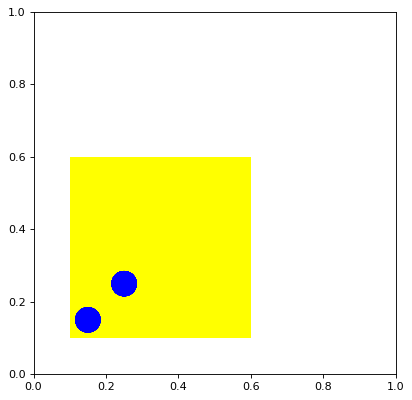

In [232]:


                                    
                                              
display(
    type_input, 
    defence_type_input, 
    signal_level_input,
    profile_input,
    clarity_input_text,
    clarity_input,
    width_input_text, 
    width_input, 
    height_input_text, 
    height_input, 
    run_btn
)
